In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("./subjects/")
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import tensorflow as tf
import time
import random, math
import tensorflow_probability as tfb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import  euclidean_distances
from Utils_Functions import KLdivergence
from sklearn.feature_selection import SelectKBest, SelectFpr,SelectPercentile 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from aif360.sklearn.metrics import equal_opportunity_difference,average_odds_difference
from Utils_Functions import generate_dataset, eod
import glob
import re

#dataset ='Bank'
for dataset in ['Adult']:
    if dataset == 'Adult':
        sens_index = 7
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'adult_org-Copy1.csv'
        alg_list = ['pc','ges','simy']
        
    if dataset == 'Compas':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'compas-Copy1'
        alg_list = ['ges','pc']
        
    if dataset == 'Bank':
        sens_index = 0
        priv_group = 5
        unpriv_group = 3
        data_file_name = 'bank'
        alg_list = ['ges']
        
    if dataset == 'Heart':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        data_file_name = 'heart_processed_1'
        alg_list = ['ges']
        
    if dataset == 'Law':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'law.csv'
        alg_list = ['ges','simy']

    if dataset == 'Student':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        alg_list = ['simy','pc']
        data_file_name = 'students-processed_2'
        
    df = pd.read_csv('./subjects/datasets/'+data_file_name)
    df =  df.drop_duplicates().reset_index(drop=True)

    X1 = df.to_numpy()[:,:-1]
    Y1 = df.to_numpy()[:,-1].astype(int)
    num_cluster = 100
    try :
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster), 'rb') as f:
            KMean = pickle.load(f)
    except:
        KMean = KMeans(n_clusters=num_cluster)
        KMean.fit(X1)
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster),'wb') as f:
            pickle.dump(KMean,f)

    ave_dist =[] 
    for i in range(KMean.n_clusters):
        mean_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
        std_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
        ave_dist.append(mean_dist + (2 * std_dist))
        #ave_dist.append(euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).max())
    final_dic = {}
    for Algorithm in alg_list:
        print('Algorithm', Algorithm)
        for edge_list_filename in glob.glob('./'+dataset+'_Analysis/'+Algorithm+'/PP/*.csv'):
            print(edge_list_filename)
            file_num = int(re.findall(r'\d+', edge_list_filename.split('/')[-1])[0])
            RQ1_res = np.load('./'+dataset+'_Analysis/RQ1/'+dataset+'_'+Algorithm+'_RQ1_results.npy')
            if RQ1_res[np.where(RQ1_res[:,1].astype(int)==file_num)[0]][0][2].astype(float)==0.0:
                print('No',file_num)
                continue
            try:
                graph_filename = './'+dataset+'_Analysis/'+Algorithm+'/DAGs/'+dataset+'_'+Algorithm+'_DAG_{file_num}.csv'.format(file_num=file_num)
                graph = pd.read_csv(graph_filename)
                #edge_list_filename = './'+dataset+'_Analysis/'+Algorithm+'/PP/'+dataset+'_'+Algorithm+'_pp_{file_num}.csv'.format(file_num=file_num)
                edges_list = pd.read_csv(edge_list_filename)
                
                if dataset=='Bank' and Algorithm=='simy':
                    graph.columns = [i.replace('1','') for i in graph.columns]
                    graph[graph.columns[0]] = [i.replace('1','') for i in graph[graph.columns[0]]]
                    edges_list.columns = [i.replace('1','') for i in edges_list.columns]
                edges_list = edges_list[edges_list.columns[1:-1]]

            except:
                print('Not a DAG! ',file_num)
                continue
            
            X1_coef = edges_list.to_numpy()
            KMean_coef = KMeans(n_clusters=100)
            KMean_coef.fit(X1_coef)
            
            for i in range(KMean_coef.n_clusters):
                #print('Coef ',i)
                weights_ind = np.random.choice(np.where(KMean_coef.labels_==i)[0])
                edges = edges_list.iloc[weights_ind]

                drop_AOD = []
                None_model = []
                drop_EOD ={}
                for j in range(10):
                    final_df, succ_rate = generate_dataset(df, graph, edges, ave_dist, KMean.cluster_centers_ ,sens_index, priv_group, unpriv_group)

                    if succ_rate==0.0 :
                        continue

                    X2 = final_df.to_numpy()[:,:-1]
                    Y2 = final_df.to_numpy()[:,-1].astype(int)
                    A2 = X2[:,sens_index]

                    model = LogisticRegression()
                    model.fit(X2,Y2)

                    preds_None = model.predict(X2)
                    acc_None = accuracy_score(Y2,preds_None)
                    f1_None = f1_score(Y2,preds_None)
                    AOD_None = round(average_odds_difference(Y2, preds_None,prot_attr=A2,priv_group=priv_group ),3)
                    EOD_None = eod(Y2, preds_None,sens=A2, priv=priv_group, unpriv=unpriv_group)        
                    None_model.append([EOD_None,acc_None,f1_None])
                    #print('Success rate DAG', file_num, succ_rate)
                    for com_num in range(1,5):
                        for comb in itertools.combinations(list(final_df.columns[:sens_index]) +list(final_df.columns[sens_index+1:-1]), com_num):
                            if comb not in drop_EOD.keys():
                                drop_EOD[comb] = []
                            X_new = final_df[[feat  for feat in final_df.columns if feat not in comb]].to_numpy()[:,:-1]

                            model = LogisticRegression()
                            model.fit(X_new,Y2)
                            preds_new = model.predict(X_new)
                            acc_temp = accuracy_score(Y2,preds_new)
                            f1_temp = f1_score(Y2,preds_new)
                            AOD = round(average_odds_difference(Y2, preds_new,prot_attr=A2,priv_group=priv_group ),3)
                            EOD = eod(Y2, preds_new,sens=A2, priv=priv_group, unpriv=unpriv_group)
                            acc_diff = round(acc_temp - acc_None,2)
                            f1_diff = round(f1_temp- f1_None,2)
                            EOD_diff = EOD - EOD_None
                            AOD_diff = AOD - AOD_None
                            EOD_diff_abs = abs(EOD) - abs(EOD_None)
                            AOD_diff_abs = abs(AOD) - abs(AOD_None)
        #                     print(EOD_diff)
        #                     if EOD_diff>0.1:
        #                         input(comb)
                            drop_EOD[comb].append([EOD_diff, acc_diff, f1_diff])

                for comb in drop_EOD.keys():

                    drop_EOD[comb]= np.mean(drop_EOD[comb],axis=0)

                final_dic[Algorithm+'_DAG_{file_num}_{weight_ind}'.format(file_num=file_num,weight_ind=weights_ind)] = drop_EOD
                

    np.save('./Overview_Figures/Adult_final_dic_'+Algorithm+'.npy',final_dic)

Algorithm pc
./Adult_Analysis/pc/PP/Adult_pc_pp_64.csv


In [4]:

np.save('./Overview_Figures/Adult_final_dic_'+Algorithm+'.npy',final_dic)

In [24]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("./subjects/")
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import tensorflow as tf
import time
import random, math
import tensorflow_probability as tfb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import  euclidean_distances
from Utils_Functions import KLdivergence
from sklearn.feature_selection import SelectKBest, SelectFpr,SelectPercentile 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from aif360.sklearn.metrics import equal_opportunity_difference,average_odds_difference
from Utils_Functions import generate_dataset, eod
import glob
import re, itertools

def generate_dataset_shift(data, graph, edges, sens_index,priv_group, unpriv_group):

    dataset_types = [str(data[i].dtype) for i in data.columns]
    succ_generated = 0
    generation_coef = 1
    graph_dic ={}
    for i in graph.columns[1:]:
        if np.where(graph[i])[0].shape[0]==0:
            graph_dic[i]=None
        else:
            graph_dic[i]= graph['Unnamed: 0'][np.where(graph[i])[0]].values

    final_df = pd.DataFrame(columns = data.columns) 
    trial = 0
    not_interesting = False
    while final_df.shape[0]<data.shape[0]:

        if trial > 20:
            not_interesting = True
            return None , False
        df_new_dic ={}
        for edge in graph.sum().index[np.where(graph.sum()==0)[0]]:
            df_new_dic[edge] = np.random.choice(np.unique(data[edge]), size = data.shape[0]*generation_coef) 

        statring_atts = graph.sum().index[np.where(graph.sum()==0)[0]]
        
        while statring_atts.shape[0] != graph['Unnamed: 0'].shape[0]:
            
            for att in graph_dic.keys():
                if att not in statring_atts:
                    if 0 in  [1 if graph_dic[att][i] in statring_atts else 0 for i in range(graph_dic[att].shape[0])]:

                        continue
                    else:
                        edge_logits = 0
                        
                        for cause in graph_dic[att]:
                            edge_logits += (edges[cause+att] * df_new_dic[cause])
                        if np.unique(data[att]).shape[0]==2:
                            df_new_dic[att] =  tfb.distributions.Bernoulli(logits=edge_logits + edges[att+'0'] ).sample().numpy()
                        elif 'float' in dataset_types[np.where(data.columns==att)[0][0]]:

                            df_new_dic[att] =  tfb.distributions.Normal(loc=(edge_logits+ edges[att+'0']), scale= edges['sigma_h']).sample().numpy()
                        
                        else:    
                            df_new_dic[att] =  tfb.distributions.Poisson(rate=tf.exp(edge_logits+ edges[att+'0']) ).sample().numpy()  

                        statring_atts = np.append(statring_atts,att) 

        new_df = pd.DataFrame(columns = data.columns)
        for col in new_df.columns:
            new_df[col] = df_new_dic[col]
        
        ind_inf = np.unique(np.where(new_df>data.max())[0])
        new_df.drop(ind_inf,axis=0,inplace=True)
        for col in range(new_df.columns.shape[0]):
            new_df[new_df.columns[col]]=new_df[new_df.columns[col]].astype(dataset_types[col])
        if new_df.shape[0]<1:
            return None , False
        X2 = new_df.to_numpy()[:,:-1]
        Y2 = new_df.to_numpy()[:,-1]
        #dist = euclidean_distances(X2, centroids)
        #succ_generated += new_df.iloc[np.where((ave_dist>=dist).sum(1)>0)].shape[0]
        final_df = pd.concat([final_df,new_df]).reset_index(drop=True)
        final_df = final_df.drop_duplicates()


            
        trial += 1
   
    #final_df = final_df.astype(int)
    Y2 = final_df.to_numpy()[:,-1]
    if (Y2.sum()/Y2.shape[0]< 0.06) or (Y2.sum()/Y2.shape[0]> 0.95):
        return None,  False
    if priv_group not in final_df[final_df.columns[sens_index]].values or unpriv_group not in final_df[final_df.columns[sens_index]].values:
        return None,  False

    return final_df, True

#dataset ='Bank'
for dataset in ['Adult']:
    if dataset == 'Adult':
        sens_index = 7
        sensitive_name = 'gender'
        priv_group = 1  #male
        unpriv_group = 0#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'adult_org-Copy1.csv'
        graph_base_filename ='./Adult_Analysis/ges/DAGs/Adult_ges_DAG_1.csv'
        edge_list_base_filename = './Adult_Analysis/ges/PP/Adult_ges_pp_1.csv'
        alg_list = ['ges','simy']
        hp_ind = 37
    if dataset == 'Compas':
        sens_index = 1
        sensitive_name = 'race'
        priv_group = 1  #male
        unpriv_group = 0#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'compas-Copy1'
        graph_base_filename ='./Compas_Analysis/pc/DAGs/Compas_pc_DAG_13.csv'
        edge_list_base_filename = './Compas_Analysis/pc/PP/Compas_pc_pp_13.csv'
        alg_list = ['ges','pc']
        hp_ind = 60
    if dataset == 'Bank':
        sens_index = 0
        sensitive_name = 'age'
        priv_group = 5  #male
        unpriv_group = 3#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'bank'
        graph_base_filename ='./Bank_Analysis/ges/DAGs/Bank_ges_DAG_8.csv'
        edge_list_base_filename = './Bank_Analysis/ges/PP/Bank_ges_pp_8.csv'
        alg_list = ['ges']
        hp_ind = 22
    if dataset == 'Law':
        sens_index = 0
        sensitive_name = 'sex'
        priv_group = 1  #male
        unpriv_group = 0#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'law.csv'
        graph_base_filename ='./Law_Analysis/ges/DAGs/Law_ges_DAG_15.csv'
        edge_list_base_filename = './Law_Analysis/ges/PP/Law_ges_pp_15.csv'
        alg_list = ['ges','simy']
        hp_ind = 22
    if dataset == 'Student':
        sens_index = 0
        sensitive_name = 'sex'
        priv_group = 1  #male
        unpriv_group = 0#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'students-processed_2'
        graph_base_filename ='./Student_Analysis/pc/DAGs/Student_pc_DAG_1.csv'
        edge_list_base_filename = './Student_Analysis/pc/PP/Student_pc_pp_1.csv'
        alg_list = ['simy','pc']
        hp_ind = 9
    if dataset == 'Heart':
        sens_index = 0
        sensitive_name = 'sex'
        priv_group = 1  #male
        unpriv_group = 0#female
        favorable_label  = 1.0
        unfavorable_label = 0.0
        data_file_name = 'heart_processed_1'
        graph_base_filename ='./Heart_Analysis/ges/DAGs/Heart_ges_DAG_4.csv'
        edge_list_base_filename = './Heart_Analysis/ges/PP/Heart_ges_pp_4.csv'
        alg_list = ['ges']
        hp_ind = 10
        
    df = pd.read_csv('./subjects/datasets/'+data_file_name)
    df =  df.drop_duplicates().reset_index(drop=True)

    X1 = df.to_numpy()[:,:-1]
    Y1 = df.to_numpy()[:,-1].astype(int)
    num_cluster = 100
    try :
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster), 'rb') as f:
            KMean = pickle.load(f)
    except:
        KMean = KMeans(n_clusters=num_cluster)
        KMean.fit(X1)
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster),'wb') as f:
            pickle.dump(KMean,f)

    ave_dist =[] 
    for i in range(KMean.n_clusters):
        mean_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
        std_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
        ave_dist.append(mean_dist + (2 * std_dist))

    drop_Eod_diff_max = [0,0,0,0,0,0]
    drop_Eod_diff_min = [0,0,0,1,0,0]
    final_dic = {}

    for Algorithm in alg_list:

        for filename in glob.glob('./'+dataset+'_Analysis/RQ2/'+Algorithm+'*.npy'):
            

            file_num = int(re.findall(r'\d+', filename.split('/')[-1])[0])


            #input(filename)
            res = np.load(filename)
            if 'drop' in filename:continue
            if  'EOD' in filename:


                if res[:,4].max()> drop_Eod_diff_max[3]:
                    drop_Eod_diff_max = [Algorithm,file_num,res[res[:,4].argmax(),1],res[:,4].max() , res[res[:,4].argmax(),5],res[res[:,4].argmax(),7]]


                if res[:,4].min()< drop_Eod_diff_min[3]:
                    drop_Eod_diff_min = [Algorithm,file_num,res[res[:,4].argmin(),1],res[:,4].min(), res[res[:,4].argmin(),6],res[res[:,4].argmin(),7  ]  ]  

    #Base dag
    RQ_res =[] 
    for filename in glob.glob('./'+dataset+'_Analysis/RQ1/*.npy'):
            RQ_res += np.load(filename).tolist()

    max_ind = np.array(RQ_res)[:,2].astype(float).argmax()
    dag_base_filename = './'+dataset+'_Analysis/'+RQ_res[max_ind][0]+'/DAGs/'+dataset+'_'+RQ_res[max_ind][0]+'_DAG_'+RQ_res[max_ind][1]+'.csv'
    
    # drop
    pert_alg_max  = drop_Eod_diff_max[0]
    pert_file_num_max = int(drop_Eod_diff_max[1])
    pert_weight_ind_max = int(drop_Eod_diff_max[2])
    dag_pert_filname_max = './'+dataset+'_Analysis/'+pert_alg_max+'/DAGs/'+dataset+'_'+pert_alg_max+'_DAG_'+str(pert_file_num_max)+'.csv'

    pert_alg_min  = drop_Eod_diff_min[0]
    pert_file_num_min = int(drop_Eod_diff_min[1])
    pert_weight_ind_min = int(drop_Eod_diff_min[2])
    dag_pert_filname_min = './'+dataset+'_Analysis/'+pert_alg_min+'/DAGs/'+dataset+'_'+pert_alg_min+'_DAG_'+str(pert_file_num_min)+'.csv'

    SelectKBest_final_EOD=[]
    SelectFpr_final_EOD=[]
    SelectPercentile_final_EOD=[]
    None_model_final_EOD = []
    SelectKBest_final_AOD=[]
    SelectFpr_final_AOD=[]
    SelectPercentile_final_AOD=[]
    None_model_final_AOD = []
    drop_final_EOD = []
    drop_final_AOD = []
    dag_space = [[dag_pert_filname_min,pert_file_num_min,pert_weight_ind_min,pert_alg_min],[dag_pert_filname_max,pert_file_num_max,pert_weight_ind_max,pert_alg_max]]
    final_dic = {}
    
    
    
    dag_space = []
    for Algorithm in ['pc','ges','simy']:
        dag_space += glob.glob('./'+dataset+'_Analysis/'+Algorithm+'/PP/*.csv')

    for dag in dag_space:
        print(dag)
        file_num = int(re.findall(r'\d+', dag.split('/')[-1])[0])
        if 'pc' in dag:Algorithm = 'pc'
        elif 'ges' in dag:Algorithm = 'ges'
        elif 'simy' in dag:Algorithm = 'simy'
            
            
        #graph = pd.read_csv('./'+dataset+'_Analysis/'+Algorithm+'/DAGs/Adult_'+Algorithm+'_'+str(file_num)+'.csv')
        graph = pd.read_csv('./Adult_Analysis/simy/DAGs/Adult_simy_DAG_3.csv')
        edge_list_filename = dag# './'+dataset+'_Analysis/'+dag[3]+'/PP/'+dataset+'_'+dag[3]+'_pp_'+str(dag[1])+'.csv'
        edges_list = pd.read_csv('./Adult_Analysis/simy/PP/Adult_simy_pp_3.csv')
        edges = edges_list[edges_list.columns[1:-1]].iloc[107]

        
        
        
        
#     for dag in dag_space:
#         graph = pd.read_csv(dag[0])
#         edge_list_filename =  './'+dataset+'_Analysis/'+dag[3]+'/PP/'+dataset+'_'+dag[3]+'_pp_'+str(dag[1])+'.csv'
#         edges_list = pd.read_csv(edge_list_filename)
#         edges = edges_list[edges_list.columns[1:-1]].iloc[dag[2]]
        SelectKBest_EOD=[]
        SelectFpr_EOD=[]
        SelectPercentile_EOD=[]
        SelectKBest_AOD=[]
        SelectFpr_AOD=[]
        SelectPercentile_AOD=[]
        drop_AOD = []
        None_model = []
        drop_EOD ={}
        for j in range(10):
            final_df, succ_rate = generate_dataset(df, graph, edges, ave_dist, KMean.cluster_centers_ ,sens_index, priv_group, unpriv_group)

            if succ_rate==0.0 :
                continue

            X2 = final_df.to_numpy()[:,:-1]
            Y2 = final_df.to_numpy()[:,-1].astype(int)
            A2 = X2[:,sens_index]

            model = LogisticRegression()
            model.fit(X2,Y2)

            preds_None = model.predict(X2)
            acc_None = accuracy_score(Y2,preds_None)
            f1_None = f1_score(Y2,preds_None)
            AOD_None = round(average_odds_difference(Y2, preds_None,prot_attr=A2,priv_group=priv_group ),3)
            EOD_None = eod(Y2, preds_None,sens=A2, priv=priv_group, unpriv=unpriv_group)        
            None_model.append([EOD_None,acc_None,f1_None])
            #print('Success rate DAG', file_num, succ_rate)
            for com_num in range(1,4):
                for comb in itertools.combinations(list(final_df.columns[:sens_index]) +list(final_df.columns[sens_index+1:-1]), com_num):
                    if comb not in drop_EOD.keys():
                        drop_EOD[comb] = []
                    X_new = final_df[[feat  for feat in final_df.columns if feat not in comb]].to_numpy()[:,:-1]

                    model = LogisticRegression()
                    model.fit(X_new,Y2)
                    preds_new = model.predict(X_new)
                    acc_temp = accuracy_score(Y2,preds_new)
                    f1_temp = f1_score(Y2,preds_new)
                    AOD = round(average_odds_difference(Y2, preds_new,prot_attr=A2,priv_group=priv_group ),3)
                    EOD = eod(Y2, preds_new,sens=A2, priv=priv_group, unpriv=unpriv_group)
                    acc_diff = round(acc_temp - acc_None,2)
                    f1_diff = round(f1_temp- f1_None,2)
                    EOD_diff = EOD - EOD_None
                    AOD_diff = AOD - AOD_None
                    EOD_diff_abs = abs(EOD) - abs(EOD_None)
                    AOD_diff_abs = abs(AOD) - abs(AOD_None)
#                     print(EOD_diff)
#                     if EOD_diff>0.1:
#                         input(comb)
                    drop_EOD[comb].append([EOD_diff, acc_diff, f1_diff])
        
        for comb in drop_EOD.keys():

            drop_EOD[comb]= np.mean(drop_EOD[comb],axis=0)
        
        final_dic[dag[0].split('/')[-1]] = drop_EOD
        input()
    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectKbest_EOD_' + str(file_num)+'.npy',SelectKBest_final_EOD)
    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectKbest_AOD_' + str(file_num)+'.npy',SelectKBest_final_AOD)

    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectFpr_EOD_' + str(file_num)+'.npy',SelectFpr_final_EOD)
    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectFpr_AOD_' + str(file_num)+'.npy',SelectFpr_final_AOD)

    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectPercentile_EOD_' + str(file_num)+'.npy',SelectPercentile_final_EOD)
    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_SelectPercentile_AOD_' + str(file_num)+'.npy',SelectPercentile_final_AOD)

    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_drop_EOD_' + str(file_num)+'.npy',drop_final_EOD)
    #     np.save('./'+dataset+'_Analysis/RQ4/'+Algorithm+'_drop_AOD_' + str(file_num)+'.npy',drop_final_AOD)
np.save('./Overview_Figures/Adult_final_dic_drop_pc.npy',final_dic)

./Adult_Analysis/pc/PP/Adult_pc_pp_64.csv


KeyboardInterrupt: Interrupted by user

In [87]:
pd.read_csv('./subjects/datasets/bank')

,age,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,label
0,5,3,0,3,0,62,1,0,0,5,4,26,1,1,0,0,0
1,4,10,2,1,0,20,1,0,0,5,4,15,1,1,0,0,0
2,3,5,0,1,0,20,1,1,0,5,4,7,1,1,0,0,0
3,4,7,0,0,0,50,1,0,0,5,4,9,1,1,0,0,0
4,3,1,2,0,0,20,0,0,0,5,4,19,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,5,10,0,3,0,36,0,0,2,17,10,97,3,1,0,0,1
45207,7,9,1,2,0,54,0,0,2,17,10,45,2,1,0,0,1
45208,7,9,0,1,0,134,0,0,2,17,10,99,5,0,1,3,1
45209,5,7,0,1,0,33,0,0,1,17,10,50,4,1,0,0,0


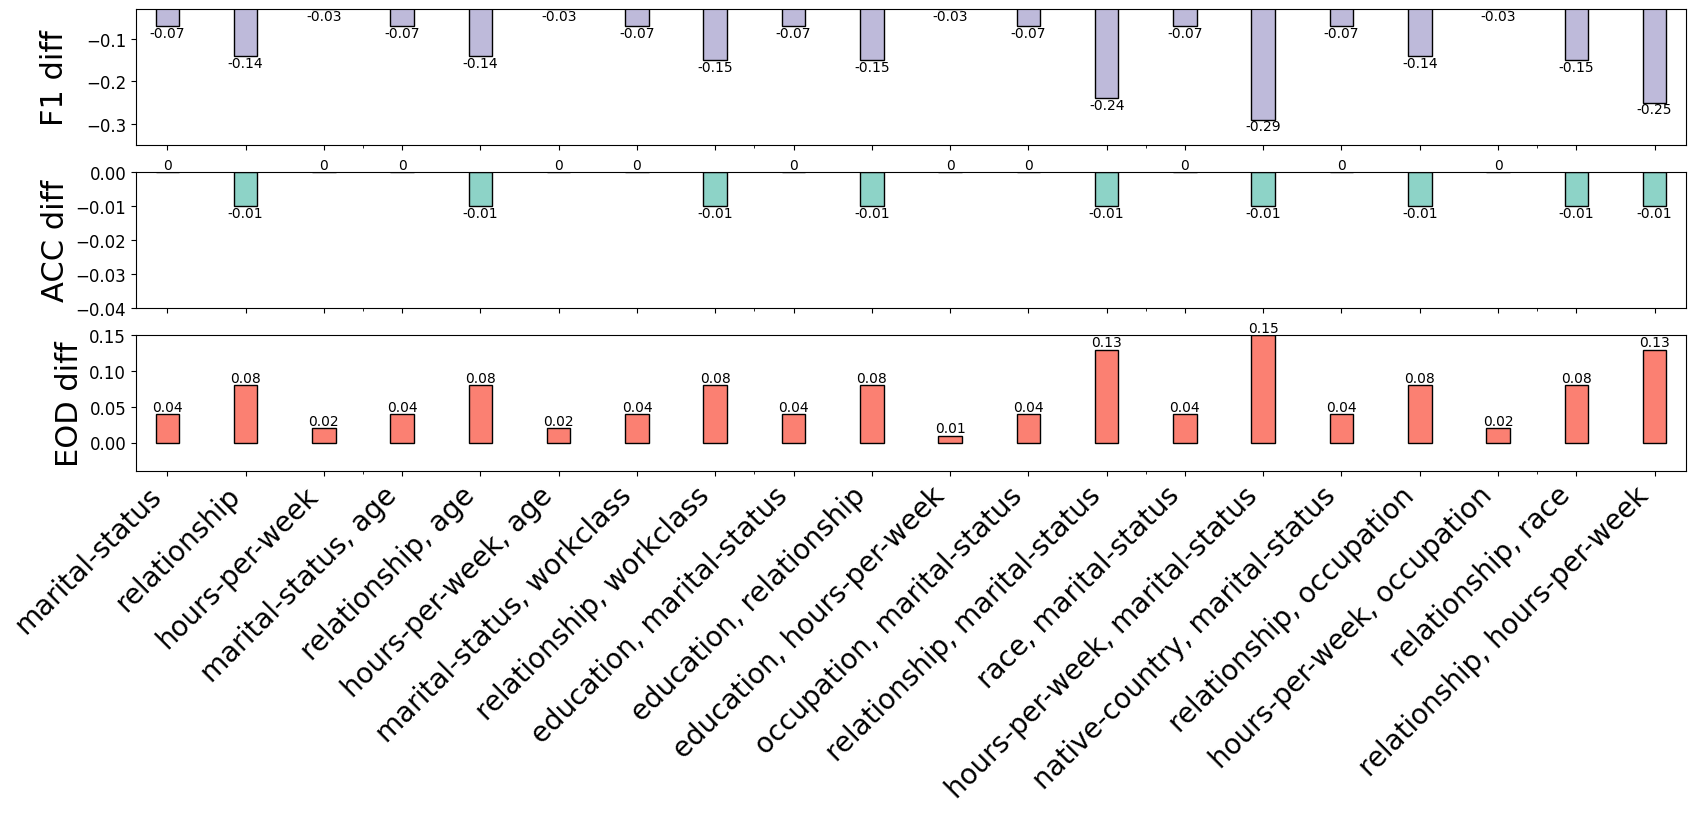

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
final_dic = dict(np.load('./Overview_Figures/Adult_final_dic_drop_2.npy',allow_pickle=True).item())

#Higher
#dag = 'Adult_simy_DAG_1.csv'
dag = list(final_dic.keys())[1]
#cols = pd.read_csv('./subjects/datasets/compas').columns
feat_name=[]
for feats in list(final_dic[dag].keys()):

    #feats = str(feats).replace('j','juv_count').replace('p','priors_count').replace('d','charge_degree').replace('d','charge_degree')
    temp = set()
    for i in range(len(feats)):
        
        if feats[i]=='w':
            temp.add(feats[i].replace('w','workclass'))
        elif feats[i]=='e':
            temp.add(feats[i].replace('e','education'))
        elif feats[i]=='m':
            temp.add(feats[i].replace('m','marital-status'))
        elif feats[i]=='o':
            temp.add(feats[i].replace('o','occupation'))
        elif feats[i]=='r':
            temp.add(feats[i].replace('r','relationship'))
        elif feats[i]=='hr':
            temp.add(feats[i].replace('hr','hours-per-week'))
        elif feats[i]=='n':
            temp.add(feats[i].replace('n','native-country'))
        else:
            
            temp.add(feats[i])

    feat_name.append(str(temp).replace('{','').replace('}','').replace("'",''))
ind_2=[]
for i in range(len(feat_name)):
    if len(feat_name[i].split(','))<=3 and np.array(list(final_dic[dag].values()))[:,0][i]>0.01:
        ind_2.append(i)    
#ind = 343
EODs = np.round(np.array(list(final_dic[dag].values()))[:,0],2)[ind_2][[i for i in range(8)]+[ i for i in range(9,21)]]
Accs = np.round(np.array(list(final_dic[dag].values()))[:,1],2)[ind_2][[i for i in range(8)]+[ i for i in range(9,21)]]
F1s = np.round(np.array(list(final_dic[dag].values()))[:,2],2)[ind_2][[i for i in range(8)]+[ i for i in range(9,21)]]    
#print('edge and step_size',drop_analysis_result[ind][:2])
feat_name = np.array(feat_name)[ind_2][[i for i in range(8)]+[ i for i in range(9,21)]]

#indices = np.where(EODs<-0.00)[0]
                


plotdata = pd.DataFrame({
    "EOD": EODs,
    "Acc": Accs,
    "F1": F1s
}, index=np.array(feat_name))



fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True)
colors = ["#fb8072",'#8dd3c7', "#bebada"]

plot1 = plotdata['EOD'].plot(ax=ax3, rot=45, kind="bar", y='EOD', figsize=(20, 6), legend=False,
                            width=0.3, color=colors[0], ylabel='EOD Diff', edgecolor='black',
                            ylim=(plotdata['EOD'].min() - 0.05, plotdata['EOD'].max()),fontsize=12)
plot2 = plotdata['Acc'].plot(ax=ax2, rot=45, kind="bar", y='Acc', figsize=(20, 6), legend=False,
                            width=0.3, color=colors[1], ylabel='ACC Diff', edgecolor='black',
                            ylim=(plotdata['Acc'].min() - 0.03, plotdata['Acc'].max()),fontsize=12)
plot3 = plotdata['F1'].plot(ax=ax1, rot=45, kind="bar", y='F1', figsize=(20, 6), legend=False,
                           width=0.3, color=colors[2], ylabel='F1 Diff', edgecolor='black',
                           ylim=(plotdata['F1'].min() - 0.06, plotdata['F1'].max()),fontsize=12)


plot1.set_ylabel('EOD diff', fontsize = 22)
plot2.set_ylabel('ACC diff', fontsize = 22)
plot3.set_ylabel('F1 diff', fontsize = 22, labelpad=12)
plot1.bar_label(plot1.containers[0])
plot2.bar_label(plot2.containers[0])
plot3.bar_label(plot3.containers[0])

# Shift x-axis labels to the left
pad = 0.1  # Adjust this value according to your preference

ax3.set_xticklabels(np.array(feat_name).tolist(), ha='right', rotation=45, fontsize=20, x=-pad)

# fig.tight_layout()
fig.show()


In [84]:
len(ind_2)

24

(array([1, 2, 3]),
 [Text(1, 0, 'SelectKbest'),
  Text(2, 0, 'SelectFpr'),
  Text(3, 0, 'SelectPercentile')])

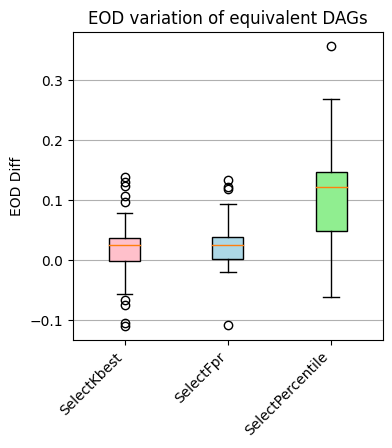

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
# Creating dataset
dataset = 'Adult'
if dataset == 'Adult':
    alg_list = ['ges','simy']
elif dataset == 'Compas':
    alg_list = ['ges','pc']
elif dataset == 'Bank':
    alg_list = ['ges'] 
elif dataset == 'Law':
    alg_list = ['ges','simy']
elif dataset == 'Student':
    alg_list = ['simy','pc']
elif dataset == 'Heart':
    alg_list = ['ges']
    
drop_Eod_diff_abs_final = []
drop_Eod_diff_final = []
drop_Aod_diff_abs_final = []
drop_Aod_diff_final = [] 

SelectKbest_Eod_diff_abs_final = []
SelectKbest_Eod_diff_final = []
SelectKbest_Aod_diff_abs_final = []
SelectKbest_Aod_diff_final = [] 

SelectFpr_Eod_diff_abs_final = []
SelectFpr_Eod_diff_final = []
SelectFpr_Aod_diff_abs_final = []
SelectFpr_Aod_diff_final = [] 

SelectPercentile_Eod_diff_abs_final = []
SelectPercentile_Eod_diff_final = []
SelectPercentile_Aod_diff_abs_final = []
SelectPercentile_Aod_diff_final = [] 


drop_eod_mit_final = []
drop_eod_org_final = []
SelectFpr_eod_mit_final = []
SelectFpr_eod_org_final = []
SelectKbest_eod_mit_final = []
SelectKbest_eod_org_final = []
SelectPercentile_eod_mit_final = []
SelectPercentile_eod_org_final = []


for Algorithm in alg_list:
    
    SelectFpr_Eod_diff_abs = []
    SelectFpr_Eod_diff = []
    SelectFpr_Aod_diff_abs = []
    SelectFpr_Aod_diff = []
    
    SelectKbest_Eod_diff_abs = []
    SelectKbest_Eod_diff = []
    SelectKbest_Aod_diff_abs = []
    SelectKbest_Aod_diff = []
    
    SelectPercentile_Eod_diff_abs = []
    SelectPercentile_Eod_diff = []
    SelectPercentile_Aod_diff_abs = []
    SelectPercentile_Aod_diff = []

    
    drop_Eod_diff_abs = []
    drop_Eod_diff = []
    drop_Aod_diff_abs = []
    drop_Aod_diff = []
    
    drop_eod_mit = []
    drop_eod_org = []
    SelectFpr_eod_mit = []
    SelectFpr_eod_org = []
    SelectKbest_eod_mit = []
    SelectKbest_eod_org = []
    SelectPercentile_eod_mit = []
    SelectPercentile_eod_org = []
    for filename in glob.glob('./'+dataset+'_Analysis/RQ2/'+Algorithm+'*.npy'):
        #print(filename)
        res = np.load(filename)
        
        if res.shape[0]<1:continue
        if 'SelectFpr' in filename and 'EOD' in filename:
            SelectFpr_Eod_diff_abs += res[:,3].tolist()
            SelectFpr_Eod_diff += res[:,2].tolist()
            SelectFpr_eod_mit += res[:,2].tolist()
            SelectFpr_eod_org += res[:,3].tolist()

        elif 'SelectFpr' in filename and 'AOD' in filename:
            SelectFpr_Aod_diff_abs += res[:,3].tolist()
            SelectFpr_Aod_diff += res[:,2].tolist()

        elif 'SelectKbest' in filename and 'EOD' in filename:

            SelectKbest_Eod_diff_abs += res[:,3].tolist()
            SelectKbest_Eod_diff += res[:,2].tolist()
            SelectKbest_eod_mit += res[:,2].tolist()
            SelectKbest_eod_org += res[:,3].tolist()

        elif 'SelectKbest' in filename and 'AOD' in filename:
            SelectKbest_Aod_diff_abs += res[:,3].tolist()
            SelectKbest_Aod_diff += res[:,2].tolist()
            
        elif 'SelectPercentile' in filename and 'EOD' in filename:
            SelectPercentile_Eod_diff_abs += res[:,3].tolist()
            SelectPercentile_Eod_diff += res[:,2].tolist()
            SelectPercentile_eod_mit += res[:,2].tolist()
            SelectPercentile_eod_org += res[:,3].tolist()

        elif 'SelectPercentile' in filename and 'AOD' in filename:
            SelectPercentile_Aod_diff_abs += res[:,3].tolist()
            SelectPercentile_Aod_diff += res[:,2].tolist()


        elif 'drop' in filename and 'EOD' in filename:
            drop_Eod_diff_abs += res[:,3].tolist()
            drop_Eod_diff += res[:,2].tolist()
            drop_eod_mit += res[:,2].tolist()
            drop_eod_org += res[:,3].tolist()

        elif 'drop' in filename and 'AOD' in filename:
            drop_Aod_diff_abs += res[:,3].tolist()
            drop_Aod_diff += res[:,2].tolist()   
    
    drop_Eod_diff_abs_final += drop_Eod_diff_abs
    drop_Eod_diff_final += drop_Eod_diff
    drop_Aod_diff_abs_final += drop_Aod_diff_abs
    drop_Aod_diff_final +=  drop_Aod_diff 
    
    SelectKbest_Eod_diff_abs_final += SelectKbest_Eod_diff_abs
    SelectKbest_Eod_diff_final += SelectKbest_Eod_diff
    SelectKbest_Aod_diff_abs_final += SelectKbest_Aod_diff_abs
    SelectKbest_Aod_diff_final +=  SelectKbest_Aod_diff   
    
    SelectFpr_Eod_diff_abs_final += SelectFpr_Eod_diff_abs
    SelectFpr_Eod_diff_final += SelectFpr_Eod_diff
    SelectFpr_Aod_diff_abs_final += SelectFpr_Aod_diff_abs
    SelectFpr_Aod_diff_final +=  SelectFpr_Aod_diff   
    
    SelectPercentile_Eod_diff_abs_final += SelectPercentile_Eod_diff_abs
    SelectPercentile_Eod_diff_final += SelectPercentile_Eod_diff
    SelectPercentile_Aod_diff_abs_final += SelectPercentile_Aod_diff_abs
    SelectPercentile_Aod_diff_final +=  SelectPercentile_Aod_diff  
    
    
    drop_eod_mit_final += drop_eod_mit
    drop_eod_org_final += drop_eod_org
    SelectFpr_eod_mit_final += SelectFpr_eod_mit
    SelectFpr_eod_org_final += SelectFpr_eod_org
    SelectKbest_eod_mit_final += SelectKbest_eod_mit
    SelectKbest_eod_org_final +=  SelectKbest_eod_org
    SelectPercentile_eod_mit_final += SelectPercentile_eod_mit
    SelectPercentile_eod_org_final += SelectPercentile_eod_org
    
data_2 = SelectKbest_Eod_diff_final
data_3 = SelectFpr_Eod_diff_final
data_4 = SelectPercentile_Eod_diff_final
data = [data_2, data_3, data_4]


data_org = [SelectFpr_eod_org_final,SelectFpr_eod_mit_final]#SelectKbest_eod_mit_final, SelectFpr_eod_org_final,SelectFpr_eod_mit_final, SelectPercentile_eod_org_final,]
data_mit = [SelectKbest_eod_mit_final, SelectFpr_eod_mit_final, SelectPercentile_eod_org_final]


data = pd.DataFrame(data).T
data.columns = ['SelectKbest','SelectFpr','SelectPercentile']
all_data = data.to_numpy()
labels = data.columns
# rectangular box plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                    labels=labels)  # will be used to label x-ticks
ax1.set_title('EOD variation of equivalent DAGs')

# notch shape box plot
# bplot2 = ax2.boxplot(data_org,
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=labels)  # will be used to label x-ticks
# ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel('EOD Diff')
plt.xticks(rotation=45, ha='right')

In [28]:
len(SelectKbest_eod_org_final)

80

In [29]:
len(SelectKbest_eod_mit_final)

80

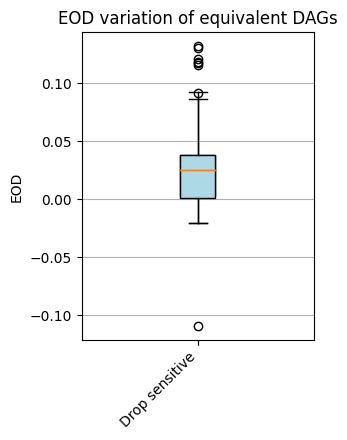

In [46]:
EOD1 = np.load('./Adult_Analysis/RQ2/simy_drop_EOD_1.npy')[:,4]
EOD2 = np.load('./Adult_Analysis/RQ2/simy_drop_EOD_3.npy')[:,4]

all_data = data_org#[EOD1,EOD2]
labels = ['Drop sensitive','']

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                    positions=[0.125, 0.125])  # will be used to label x-ticks
ax1.set_title('EOD variation of equivalent DAGs')

# # notch shape box plot
# bplot2 = ax2.boxplot(all_data,
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=labels)  # will be used to label x-ticks
# ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in [bplot1]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel('EOD')

plt.xticks(rotation=45, ha='right')
plt.show()

In [36]:
EOD1

array([0.055 , 0.0914, 0.012 , 0.017 , 0.0936, 0.0293, 0.0521, 0.0374,
       0.0163, 0.0859])

In [37]:
EOD2

array([-0.0884, -0.0819, -0.0433, -0.0531, -0.1241, -0.05  , -0.0387,
       -0.1189, -0.1096, -0.0626])

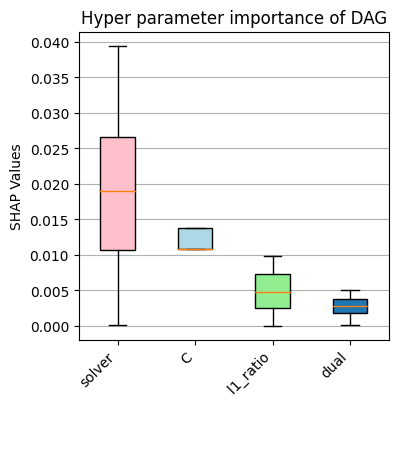

In [20]:
import numpy as np
import pandas as pd
import glob, re
from sklearn.preprocessing import LabelEncoder

dataset = 'Adult'
if dataset == 'Adult':
    sensitive_param = 7
    sensitive_name = 'gender'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'adult_org-Copy1.csv'
    graph_base_filename ='./Adult_Analysis/ges/DAGs/Adult_ges_DAG_1.csv'
    edge_list_base_filename = './Adult_Analysis/ges/PP/Adult_ges_pp_1.csv'
    alg_list = ['ges','simy']
    hp_ind = 37
filename = './'+dataset+'_Analysis/RQ3/'+dataset+'_RQ3.npy'
res = np.load(filename, allow_pickle=True)
filename = './Adult_Analysis/RQ3/Adult_RQ3_shap_values.npy'
shap_values = np.load(filename)

alg_include = np.array([1 if i in alg_list else 0 for i in res[:,1] ])
res = res[np.where(alg_include!=0)[0]]
shap_values = shap_values[np.where(alg_include!=0)[0]]

hp_ind_0 = 14
hp_ind_1 = 36

shap_ind = np.argsort(np.abs(shap_values[hp_ind_1]).mean(0))[::-1][:4]


all_data = np.abs(shap_values[hp_ind_1])[:,shap_ind]
labels = res[hp_ind_0,4:8]
labels[2] = '                     '+labels[2]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Hyper parameter importance of DAG')

# # notch shape box plot
# bplot2 = ax2.boxplot(all_data,
#                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=labels)  # will be used to label x-ticks
# ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, ):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1,]:
    ax.yaxis.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel('SHAP Values')

plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
labels[0] = '         solver'

array(['solver', 'C', 'l1_ratio', 'dual'], dtype=object)

In [10]:
len('selectpercentile')

16

In [433]:
for hp0 in range(res[:,4:8].shape[0]):
    for hp1 in range(res[:,4:8].shape[0]):
        difference_result = []
        for item in res[:,4:8][hp0]:
            if item not in res[:,4:8][hp1]:
                difference_result.append(item)

        if len(difference_result)==4:
            
            if 'l1_ratio_isna' in res[:,4:8][hp0] and 'l1_ratio' in res[:,4:8][hp0]:continue
            elif 'l1_ratio_isna' in res[:,4:8][hp1] and 'l1_ratio' in res[:,4:8][hp1]:continue
            else:
                print(hp0, hp1)
                input()
                break

14 36

36 14



In [402]:
difference_result

['solver', 'C', 'l1_ratio', 'dual']

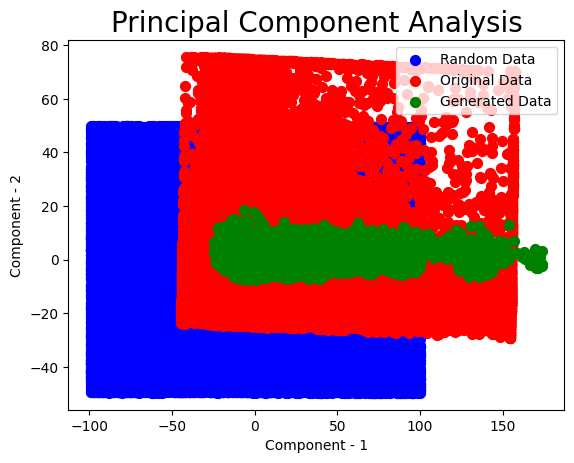

In [95]:
import sys
sys.path.append("./subjects/")
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import time
import re, random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.cluster import KMeans
import shap
import xml_parser
import xml_parser_domains
from mutation import mutate, clip_LR
from fairlearn.metrics import equalized_odds_difference
from sklearn.preprocessing import LabelEncoder
from Utils_Functions import generate_dataset, eod
import copy, pickle, glob
from sklearn.metrics.pairwise import  euclidean_distances
from sklearn.manifold import  TSNE 
from sklearn.decomposition import PCA
dataset='Bank'
if dataset == 'Adult':
    sensitive_param = 7
    sensitive_name = 'gender'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'adult_org-Copy1.csv'
    graph_base_filename ='./Adult_Analysis/ges/DAGs/Adult_ges_DAG_1.csv'
    edge_list_base_filename = './Adult_Analysis/ges/PP/Adult_ges_pp_1.csv'
    alg_list = ['ges','simy']
if dataset == 'Compas':
    sensitive_param = 1
    sensitive_name = 'race'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'compas-Copy1'
    graph_base_filename ='./Compas_Analysis/pc/DAGs/Compas_pc_DAG_13.csv'
    edge_list_base_filename = './Compas_Analysis/pc/PP/Compas_pc_pp_13.csv'
    alg_list = ['ges','pc']
if dataset == 'Bank':
    sensitive_param = 0
    sensitive_name = 'age'
    priviliged_group = 5  #male
    unpriviliged_group = 3#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'bank'
    graph_base_filename ='./Bank_Analysis/ges/DAGs/Bank_ges_DAG_8.csv'
    edge_list_base_filename = './Bank_Analysis/ges/PP/Bank_ges_pp_8.csv'
    alg_list = ['ges']
if dataset == 'Law':
    sensitive_param = 0
    sensitive_name = 'sex'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'law.csv'
    graph_base_filename ='./Law_Analysis/ges/DAGs/Law_ges_DAG_15.csv'
    edge_list_base_filename = './Law_Analysis/ges/PP/Law_ges_pp_15.csv'
    alg_list = ['ges','simy']
if dataset == 'Student':
    sensitive_param = 0
    sensitive_name = 'sex'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'students-processed_2'
    graph_base_filename ='./Student_Analysis/pc/DAGs/Student_pc_DAG_1.csv'
    edge_list_base_filename = './Student_Analysis/pc/PP/Student_pc_pp_1.csv'
    alg_list = ['simy','pc']
if dataset == 'Heart':
    sensitive_param = 0
    sensitive_name = 'sex'
    priviliged_group = 1  #male
    unpriviliged_group = 0#female
    favorable_label  = 1.0
    unfavorable_label = 0.0
    data_file_name = 'heart_processed_1'
    graph_base_filename ='./Heart_Analysis/ges/DAGs/Heart_ges_DAG_4.csv'
    edge_list_base_filename = './Heart_Analysis/ges/PP/Heart_ges_pp_4.csv'
    alg_list = ['ges']

df = pd.read_csv('./subjects/datasets/'+data_file_name)

df = df.drop_duplicates().reset_index(drop=True)
A = df[sensitive_name].to_numpy()
X = df.to_numpy()[:,:-1]
Y = df.to_numpy()[:,-1].astype(int)

num_cluster = 100
try :
    with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster), 'rb') as f:
        KMean = pickle.load(f)
except:
    KMean = KMeans(n_clusters=num_cluster)
    KMean.fit(X)
    with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster),'wb') as f:
        pickle.dump(KMean,f)

ave_dist =[] 
for i in range(KMean.n_clusters):
    mean_dist = euclidean_distances(X[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
    std_dist = euclidean_distances(X[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
    ave_dist.append(mean_dist + (2 * std_dist))




graph_base = pd.read_csv(graph_base_filename)
edges_list_base = pd.read_csv(edge_list_base_filename)

edges_base = edges_list_base[edges_list_base.columns[1:-1]].mean()
final_df_base, succ_rate_base = generate_dataset(df, graph_base, edges_base, ave_dist, KMean.cluster_centers_ ,sensitive_param, priviliged_group, unpriviliged_group)


# Random Data
rnd_df = pd.DataFrame(columns = df.columns)
for col in df.columns:
    if col!='hr':
        rnd_df[col]  = np.random.choice(np.unique(df[col]),size=df.shape[0])
    else:
        rnd_df[col]  = np.random.uniform(low=df[col].min(), high=df[col].max(), size=df.shape[0])


X_gen = final_df_base.to_numpy()[:-1]
X_org = df.to_numpy()[:-1]
X_rnd = rnd_df.to_numpy()[:-1]
# X_gen=X_gen[np.random.choice(np.where(X_gen[:,7]==0)[0],size=1000)]
# X_org=X_org[np.random.choice(np.where(X_org[:,7]==0)[0],size=1000)]
# X_rnd=X_rnd[np.random.choice(np.where(X_rnd[:,7]==0)[0],size=1000)]
pca = PCA(n_components=2)
transformed_x_org = pca.fit_transform(X_org)
transformed_x_gen = pca.fit_transform(X_gen)
transformed_x_rnd = pca.fit_transform(X_rnd)
plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("Principal Component Analysis",fontsize=20)

plt.scatter(transformed_x_rnd[:,0]
           , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})

In [96]:
from sklearn.manifold import TSNE
X_gen = final_df_base.to_numpy()[:-1]
X_org = df.to_numpy()[:-1]
X_rnd = rnd_df.to_numpy()[:-1]
# X_gen=X_gen[np.random.choice(np.where(X_gen[:,7]==0)[0],size=5000)]
# X_org=X_org[np.random.choice(np.where(X_org[:,7]==0)[0],size=5000)]
# X_rnd=X_rnd[np.random.choice(np.where(X_rnd[:,7]==0)[0],size=5000)]
TSNE = TSNE(n_components=2,method='exact', learning_rate='auto',init='random', perplexity=10)
transformed_x_org = TSNE.fit_transform(X_org)
transformed_x_gen = TSNE.fit_transform(X_gen)
transformed_x_rnd = TSNE.fit_transform(X_rnd)



plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("Principal Component Analysis",fontsize=20)

plt.scatter(transformed_x_rnd[:,0]
           , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})

KeyboardInterrupt: 

In [9]:
drop_eod_mit

[2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0]

In [10]:
res

array([[ 3.00e+00,  2.60e+01, -1.80e-03, -8.00e-04, -1.00e-03,  1.00e-03,
         0.00e+00, -2.40e-02],
       [ 3.00e+00,  3.52e+02, -7.00e-04, -7.00e-04,  0.00e+00,  0.00e+00,
         0.00e+00,  0.00e+00],
       [ 3.00e+00,  4.89e+02,  1.20e-03,  1.20e-03,  0.00e+00,  0.00e+00,
         0.00e+00,  0.00e+00],
       [ 3.00e+00,  1.54e+02, -1.80e-03, -1.30e-03, -5.00e-04,  5.00e-04,
        -2.00e-03, -2.60e-02],
       [ 3.00e+00,  1.82e+02, -1.70e-03, -1.20e-03, -5.00e-04,  5.00e-04,
        -9.00e-03, -4.40e-02],
       [ 3.00e+00,  9.40e+01, -2.10e-03, -1.10e-03, -1.00e-03,  1.00e-03,
        -2.00e-03, -2.80e-02],
       [ 3.00e+00,  2.57e+02, -1.20e-03, -9.00e-04, -3.00e-04,  3.00e-04,
        -3.00e-03, -1.90e-02],
       [ 3.00e+00,  3.96e+02,  4.00e-04,  4.00e-04,  0.00e+00,  0.00e+00,
         0.00e+00,  0.00e+00],
       [ 3.00e+00,  8.10e+01, -2.10e-03, -1.10e-03, -1.00e-03,  1.00e-03,
        -1.00e-03, -2.40e-02],
       [ 3.00e+00,  2.34e+02, -1.50e-03, -1.10e-03, -4.